In [1]:
from scipy.stats import expon
import numpy as np
from math import factorial
import matplotlib.pyplot as plt
import dill
from astropy import visualization as vis
from gammapy.data import DataStore, Observation
import scanner_interpretation as scani

with open("pkl_jugs/reduced_with_bkg.pkl","rb") as f:
    reduced = dill.load(f)

In [2]:
candidates = reduced[reduced["POISSON_SIGNIFICANCE"] < 1e-5]

### To do

1. Check fit compared to histogram and mplet dt
2. Verify on a skymap that the masked photons correspond to near the source
3. Do a time spread of the photon arrival times to guess if a cloud is passing by
4. Do a gammapy analysis
5. Ask victor if the m87 run is excluded (done)
6. check GRBCAT

In [14]:
ds = scani.getDataStores()
obs = [myds.get_observations(candidates["OBS_ID"],skip_missing=True) for myds in ds]
m87_obs = obs[1][0]
m87_mplet = candidates[-1]


Skipping missing obs_id: 137942
Skipping missing obs_id: 39669
Skipping missing obs_id: 55235
Skipping missing obs_id: 64292


In [48]:
m87_mplet

Nmax,OBS_ID,ID,RA,DEC,TIME,ENERGY,dt,da,MEDIAN_RA,MEDIAN_DEC,SkyCoord,MEDIAN_GLAT,MEDIAN_GLON,TEVCAT_SOURCE_NAME,TEVCAT_SOURCE_TYPE,TEVCAT_DISTANCES_DEG,DS_INDEX,LOCAL_BKG_PHOT_DT_EXPON_FIT,POISSON_SIGNIFICANCE
,,,,,,,,,,,"deg,deg",deg,deg,,,,,,
int64,uint32,object,object,object,object,object,float64,float64,float64,float64,SkyCoord,float64,float64,str21,str22,float64,int64,float64[2],float64
3,137942,[15612206126937 15612206129045 15616501089705],[188.66566 188.64558 188.60661],[12.210437 12.206524 12.247856],['2018-04-18T22:02:14.140618378' '2018-04-18T22:02:15.104185158'\n '2018-04-18T22:02:16.076563412'],[0.4442109 0.2899894 0.681971 ],1935944960.0,0.06990913182697338,188.6455841064453,12.210436820983887,"188.6455841064453,12.210436820983887",74.56749504739597,287.2743679359469,M 87,FRI,0.9671798904338789,1,0.963566780090332 .. 0.0044057369232177734,1.4062075141817914e-96


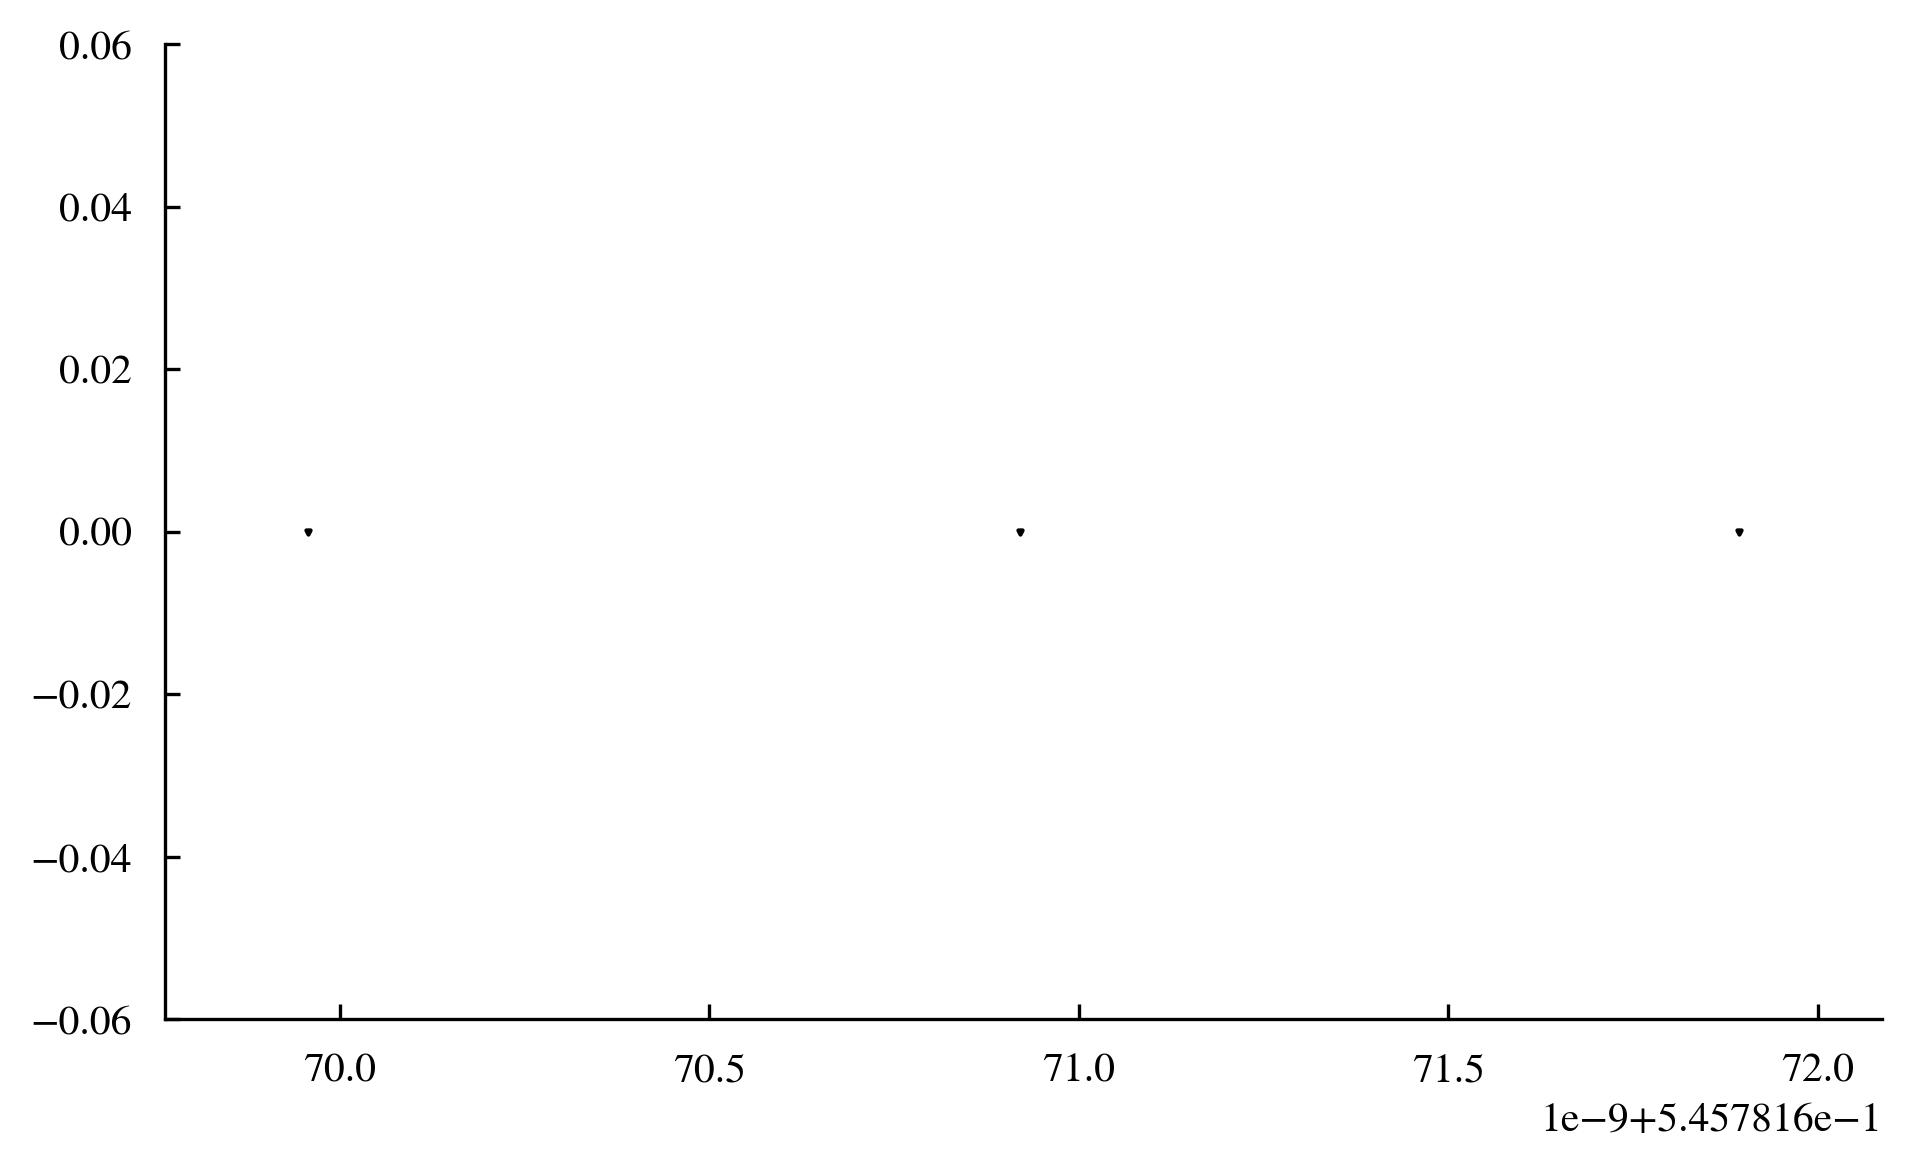

In [47]:
m87_rundist = scani.sphere_dist(m87_obs.events.table["RA"].data,m87_obs.events.table["DEC"].data,m87_mplet["MEDIAN_RA"],m87_mplet["MEDIAN_DEC"])

plt.scatter(1e-9*(m87_obs.events.table[m87_rundist<.1]["TIME"]),np.zeros_like(m87_obs.events.table[m87_rundist<.1]["TIME"]),marker="v",s=1)

In [59]:
expon.fit(np.diff(np.sort(m87_obs.events.table[m87_rundist < 0.1]["TIME"])),floc=0)

(0.0, 0.9679725170135498)

In [ ]:
dwarf = SkyCoord(283.775,-30.483,frame="fk5",unit="deg")
dwarf.separation(reduced[(reduced["OBS_ID"]==64292) * (reduced["POISSON_SIGNIFICANCE"] < 1e-5)]["SkyCoord"])

In [ ]:
h = vis.hist(np.log10(reduced["dt"]),bins="freedman",histtype="step")
plt.yscale("log")